### Import the necessary modules.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

### Import the dataset.

In [2]:
with zipfile.ZipFile("crashes.csv.zip") as z1:
    with z1.open("crashes.csv") as crashes:
        df_crashes = pd.read_csv(crashes)

In [3]:
df_crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416872 entries, 0 to 416871
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                416872 non-null  object 
 1   RD_NO                          416813 non-null  object 
 2   CRASH_DATE_EST_I               31821 non-null   object 
 3   CRASH_DATE                     416868 non-null  object 
 4   POSTED_SPEED_LIMIT             416868 non-null  float64
 5   TRAFFIC_CONTROL_DEVICE         416868 non-null  object 
 6   DEVICE_CONDITION               416868 non-null  object 
 7   WEATHER_CONDITION              416868 non-null  object 
 8   LIGHTING_CONDITION             416868 non-null  object 
 9   FIRST_CRASH_TYPE               416867 non-null  object 
 10  TRAFFICWAY_TYPE                416867 non-null  object 
 11  LANE_CNT                       126015 non-null  float64
 12  ALIGNMENT                     

### Filter the dataset to fit the business problem.


In [4]:
# Filter the dataset to only include crashes when it is raining
df_crashes = df_crashes.loc[df_crashes["WEATHER_CONDITION"] == 'RAIN']
df_crashes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36006 entries, 12 to 416854
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CRASH_RECORD_ID                36006 non-null  object 
 1   RD_NO                          35999 non-null  object 
 2   CRASH_DATE_EST_I               2270 non-null   object 
 3   CRASH_DATE                     36006 non-null  object 
 4   POSTED_SPEED_LIMIT             36006 non-null  float64
 5   TRAFFIC_CONTROL_DEVICE         36006 non-null  object 
 6   DEVICE_CONDITION               36006 non-null  object 
 7   WEATHER_CONDITION              36006 non-null  object 
 8   LIGHTING_CONDITION             36006 non-null  object 
 9   FIRST_CRASH_TYPE               36006 non-null  object 
 10  TRAFFICWAY_TYPE                36006 non-null  object 
 11  LANE_CNT                       11627 non-null  float64
 12  ALIGNMENT                      36006 non-nul

In [5]:
# Dropping null values from the target variable column
df_crashes = df_crashes.loc[df_crashes["MOST_SEVERE_INJURY"].notna()]
df_crashes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35894 entries, 12 to 416854
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CRASH_RECORD_ID                35894 non-null  object 
 1   RD_NO                          35887 non-null  object 
 2   CRASH_DATE_EST_I               2248 non-null   object 
 3   CRASH_DATE                     35894 non-null  object 
 4   POSTED_SPEED_LIMIT             35894 non-null  float64
 5   TRAFFIC_CONTROL_DEVICE         35894 non-null  object 
 6   DEVICE_CONDITION               35894 non-null  object 
 7   WEATHER_CONDITION              35894 non-null  object 
 8   LIGHTING_CONDITION             35894 non-null  object 
 9   FIRST_CRASH_TYPE               35894 non-null  object 
 10  TRAFFICWAY_TYPE                35894 non-null  object 
 11  LANE_CNT                       11598 non-null  float64
 12  ALIGNMENT                      35894 non-nul

## FEATURE ENGINEERING FOR THE BINARY TARGET VARIABLE MODELING

In [6]:
# Making most severe injury column binary
injury_binary = {'NO INDICATION OF INJURY': 0, 'NONINCAPACITATING INJURY': 1, 'REPORTED, NOT EVIDENT': 1, 'INCAPACITATING INJURY': 1, 'FATAL': 1}

df_crashes["INJURY_BINARY"] = df_crashes["MOST_SEVERE_INJURY"].map(injury_binary)
df_crashes["INJURY_BINARY"].value_counts()
# Worth noting that it is very imbalanced.

0    30036
1     5858
Name: INJURY_BINARY, dtype: int64

In [7]:
# Further filtering for the columns that we still have interest in
col_names = ['LIGHTING_CONDITION', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'MOST_SEVERE_INJURY', 'INJURY_BINARY'] # <-----

df_crashes = df_crashes[col_names]
df_crashes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35894 entries, 12 to 416854
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LIGHTING_CONDITION  35894 non-null  object 
 1   CRASH_HOUR          35894 non-null  float64
 2   CRASH_DAY_OF_WEEK   35894 non-null  float64
 3   CRASH_MONTH         35894 non-null  float64
 4   MOST_SEVERE_INJURY  35894 non-null  object 
 5   INJURY_BINARY       35894 non-null  int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 1.9+ MB


In [8]:
df_crashes.isna().sum()

LIGHTING_CONDITION    0
CRASH_HOUR            0
CRASH_DAY_OF_WEEK     0
CRASH_MONTH           0
MOST_SEVERE_INJURY    0
INJURY_BINARY         0
dtype: int64

# EDA.

### Explore the unique values of each categorical column.

In [9]:
print("\nUnique values in the 'LIGHTING_CONDITION' column:")
print(df_crashes['LIGHTING_CONDITION'].value_counts())

print("\nUnique values in the 'MOST_SEVERE_INJURY' column:")
print(df_crashes['MOST_SEVERE_INJURY'].value_counts())


Unique values in the 'LIGHTING_CONDITION' column:
DAYLIGHT                  19727
DARKNESS, LIGHTED ROAD    10780
DARKNESS                   2455
DUSK                       1556
DAWN                        999
UNKNOWN                     377
Name: LIGHTING_CONDITION, dtype: int64

Unique values in the 'MOST_SEVERE_INJURY' column:
NO INDICATION OF INJURY     30036
NONINCAPACITATING INJURY     3280
REPORTED, NOT EVIDENT        1821
INCAPACITATING INJURY         716
FATAL                          41
Name: MOST_SEVERE_INJURY, dtype: int64


### Explore the unique values of each discrete numerical column.

In [10]:
print("Unique values in the 'CRASH_HOUR' column:")
print(df_crashes['CRASH_HOUR'].value_counts().sort_index())

print("\nUnique values in the 'CRASH_DAY_OF_WEEK' column:")
print(df_crashes['CRASH_DAY_OF_WEEK'].value_counts().sort_index())

print("\nUnique values in the 'CRASH_MONTH' column:")
print(df_crashes['CRASH_MONTH'].value_counts().sort_index())

Unique values in the 'CRASH_HOUR' column:
0.0      848
1.0      789
2.0      663
3.0      568
4.0      524
5.0      606
6.0      963
7.0     1655
8.0     1867
9.0     1646
10.0    1470
11.0    1588
12.0    1772
13.0    1869
14.0    1929
15.0    2379
16.0    2525
17.0    2600
18.0    2245
19.0    1858
20.0    1610
21.0    1463
22.0    1332
23.0    1125
Name: CRASH_HOUR, dtype: int64

Unique values in the 'CRASH_DAY_OF_WEEK' column:
1.0    4339
2.0    4504
3.0    4941
4.0    5552
5.0    4813
6.0    5752
7.0    5993
Name: CRASH_DAY_OF_WEEK, dtype: int64

Unique values in the 'CRASH_MONTH' column:
1.0     1788
2.0     1549
3.0     2866
4.0     4002
5.0     3870
6.0     2816
7.0     2073
8.0     2176
9.0     2546
10.0    6077
11.0    3616
12.0    2515
Name: CRASH_MONTH, dtype: int64


### Make countplots for the unique values of each categorical column.

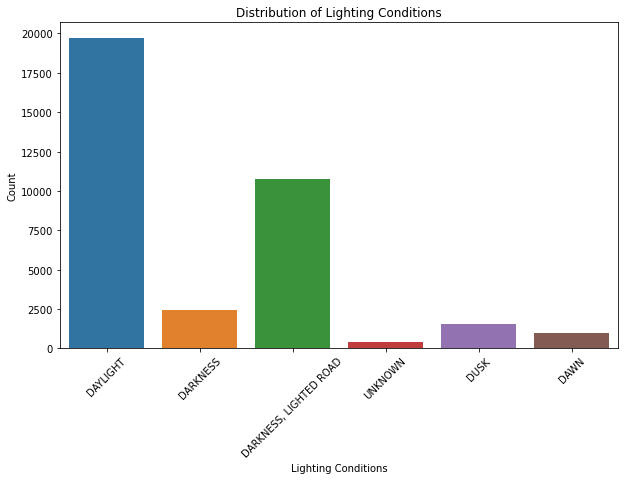

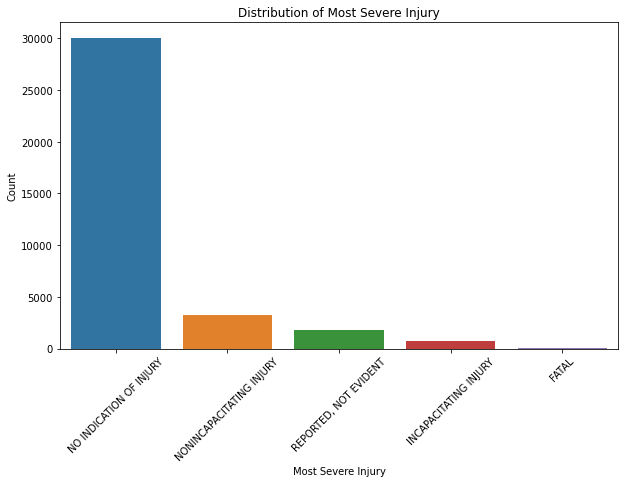

In [11]:
# Countplot for 'LIGHTING_CONDITION' with adjusted spacing between bars
plt.figure(figsize = (10, 6))
sns.countplot(data = df_crashes, x = 'LIGHTING_CONDITION', dodge = True)
plt.title('Distribution of Lighting Conditions')
plt.xlabel('Lighting Conditions')
plt.ylabel('Count')
plt.xticks(rotation = 45)  # Rotate x-axis labels if needed
plt.show()

# Countplot for 'MOST_SEVERE_INJURY' with adjusted spacing between bars
plt.figure(figsize = (10, 6))
sns.countplot(data = df_crashes, x = 'MOST_SEVERE_INJURY', dodge = True)
plt.title('Distribution of Most Severe Injury')
plt.xlabel('Most Severe Injury')
plt.ylabel('Count')
plt.xticks(rotation = 45)  # Rotate x-axis labels if needed
plt.show()

### Make countplots for the unique values of each discrete numerical column.

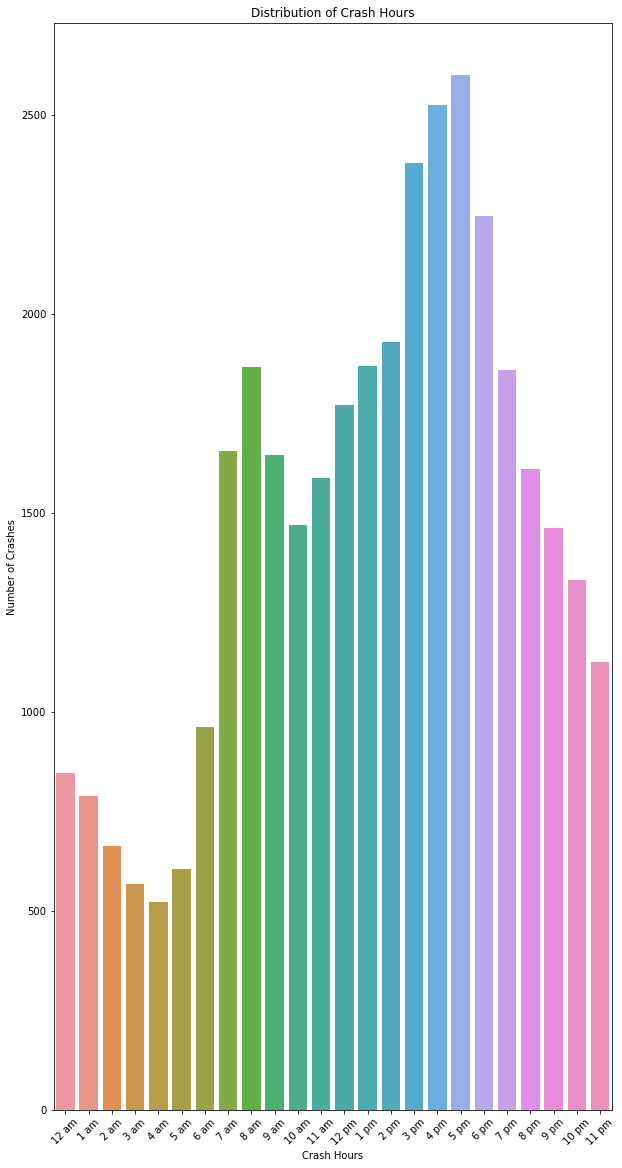

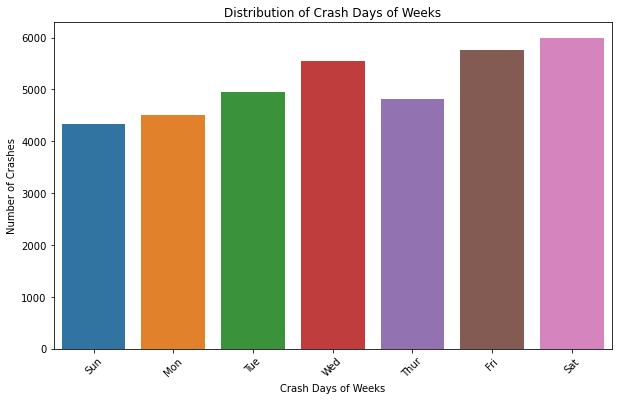

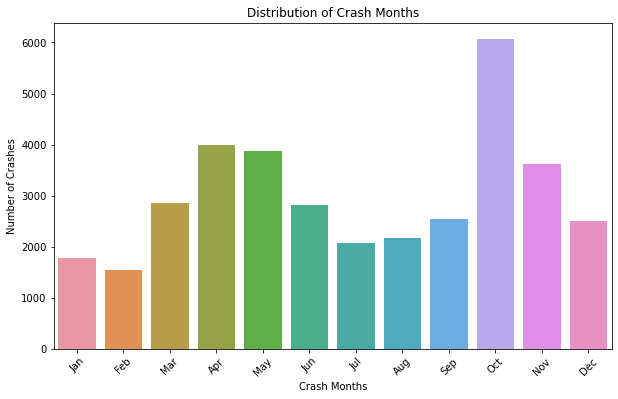

In [12]:
# Countplot for 'CRASH_HOUR'
plt.figure(figsize = (10, 20))
sns.countplot(data = df_crashes, x = 'CRASH_HOUR', dodge = True)
plt.title('Distribution of Crash Hours')
plt.xlabel('Crash Hours')
plt.ylabel('Number of Crashes')
plt.xticks(range(24), ['12 am', '1 am', '2 am', '3 am', '4 am', '5 am', '6 am', '7 am',
                       '8 am', '9 am', '10 am', '11 am', '12 pm', '1 pm', '2 pm', '3 pm',
                       '4 pm', '5 pm', '6 pm', '7 pm', '8 pm', '9 pm', '10 pm', '11 pm'], 
           rotation = 45)  # Rotate x-axis labels if needed
plt.show()

# Countplot for 'CRASH_DAY_OF_WEEK' with adjusted spacing between bars
plt.figure(figsize = (10, 6))
sns.countplot(data = df_crashes, x = 'CRASH_DAY_OF_WEEK', dodge = True)
plt.title('Distribution of Crash Days of Weeks')
plt.xlabel('Crash Days of Weeks')
plt.ylabel('Number of Crashes')
plt.xticks(range(7), ['Sun', 'Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat'], 
           rotation = 45)  # Rotate x-axis labels if needed
plt.show()

# Countplot for 'CRASH_MONTH' with adjusted spacing between bars
plt.figure(figsize = (10, 6))
sns.countplot(data = df_crashes, x = 'CRASH_MONTH', dodge = True)
plt.title('Distribution of Crash Months')
plt.xlabel('Crash Months')
plt.ylabel('Number of Crashes')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
           rotation = 45)  # Rotate x-axis labels if needed
plt.show()

### Make heatmaps of cross-tabulation between every possible 'MOST_SEVERE_INJURY' column pair.

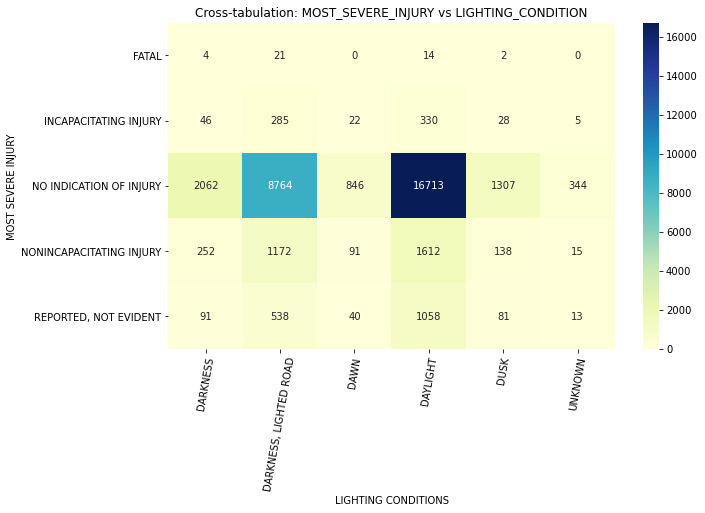

In [13]:
# Cross-tabulation between 'MOST_SEVERE_INJURY' and 'LIGHTING_CONDITION'
cross_tab_severe_lighting = pd.crosstab(df_crashes['MOST_SEVERE_INJURY'], df_crashes['LIGHTING_CONDITION'])
plt.figure(figsize = (10, 6))
sns.heatmap(cross_tab_severe_lighting, cmap = "YlGnBu", annot = True, fmt = 'd')
plt.title("Cross-tabulation: MOST_SEVERE_INJURY vs LIGHTING_CONDITION")
plt.xlabel("LIGHTING CONDITIONS")
plt.xticks(rotation = 80)  # Rotate x-axis labels if needed
plt.ylabel("MOST SEVERE INJURY")
plt.show()

In [14]:
# groupby for EDA
grouped_crashes_binary = df_crashes.groupby(['INJURY_BINARY'])

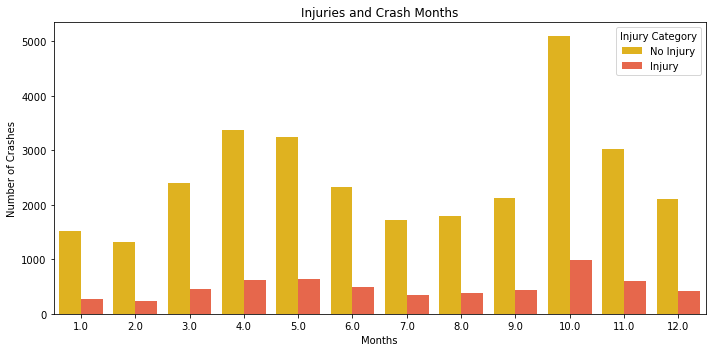

In [15]:
# A Grouped bar graph on No Injury/Injury and Crash Months

# Define a dictionary for mapping values to labels
injury_labels = {0: 'No Injury', 1: 'Injury'}

# Define custom colors for the bars
custom_colors = ['#FFC300', '#FF5733']

# Plot the countplot
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(data = df_crashes, x = 'CRASH_MONTH', hue = 'INJURY_BINARY', hue_order = [0, 1], palette = custom_colors)

ax.set_title("Injuries and Crash Months")
ax.set_xlabel("Months")
ax.set_ylabel("Number of Crashes")

plt.legend(title = 'Injury Category', labels = injury_labels.values(), loc = 'upper right')
plt.tight_layout()

# Show the plot
plt.show()

# I would have guessed more crashes during the winter months
# But there seems to be no dramatic differences between months

# BINOMIAL MODELING

### TRAIN-TEST SPLIT FOR BINOMIAL MODELING.

In [16]:
from sklearn.model_selection import train_test_split

# Split the features and target variable
X = df_crashes.drop(['INJURY_BINARY','MOST_SEVERE_INJURY'], axis = 1)  # Features
y = df_crashes.INJURY_BINARY  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

### PERFORM ONE-HOT ENCODING FOR ANY CATEGORICAL COLUMN(S) FOR BINOMIAL MODELING.

In [17]:
from sklearn.preprocessing import OneHotEncoder

# Specify the categorical columns to encode (assuming they are categorical columns)
categorical_cols = ['LIGHTING_CONDITION']

# Create an instance of the OneHotEncoder
ohe = OneHotEncoder(drop = 'first')

# Transform the categorical columns in both the training and testing sets
X_train_encoded = pd.DataFrame (ohe.fit_transform(X_train[categorical_cols]).toarray(), columns=ohe.get_feature_names_out())
X_test_encoded = pd.DataFrame (ohe.transform(X_test[categorical_cols]).toarray(), columns=ohe.get_feature_names_out())

X_train_merge = X_train.drop(['LIGHTING_CONDITION'], axis=1)
X_train_merge.reset_index(drop=True, inplace=True)
X_test_merge = X_test.drop(['LIGHTING_CONDITION'], axis=1)
X_test_merge.reset_index(drop=True, inplace=True)

X_train_encoded = pd.concat([X_train_encoded, X_train_merge], axis=1)
X_test_encoded = pd.concat([X_test_encoded, X_test_merge], axis=1)

### PERFORM SMOTE TO ADDRESS CLASS IMBALANCE (BINOMIAL).

In [18]:
from imblearn.over_sampling import SMOTE

# Create an instance of SMOTE
smote = SMOTE(random_state = 42)

# Apply SMOTE on the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train) # <-----------------------------

### APPLY A DUMMY CLASSIFIER AS THE BASELINE MODEL.

In [71]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

# Create a baseline model
dummy_model = DummyClassifier(strategy = 'most_frequent')

# Train the model on the resampled training data
dummy_model.fit(X_train_resampled, y_train_resampled)

# Predict on the testing data
y_pred = dummy_model.predict(X_test_encoded)

# Evaluate the model with a classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.84      1.00      0.91      7528
           1       0.00      0.00      0.00      1446

    accuracy                           0.84      8974
   macro avg       0.42      0.50      0.46      8974
weighted avg       0.70      0.84      0.77      8974



c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


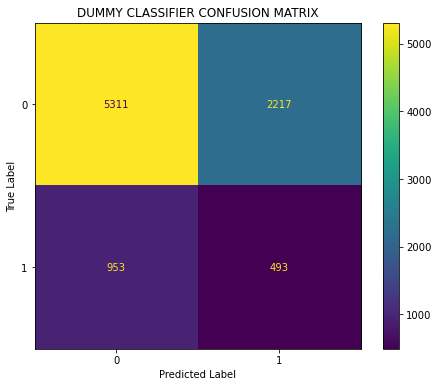

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix = cm)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)

# Add a title and axis labels
plt.title("DUMMY CLASSIFIER CONFUSION MATRIX")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot

plt.show()



### APPLY A BINOMIAL DECISION TREE MODEL.

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix


# Create an instance of the DecisionTreeClassifier
bn_tree_model = DecisionTreeClassifier(max_depth = 3)

# Train the model 
bn_tree_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the testing data
y_pred_tree = bn_tree_model.predict(X_test_encoded)

# Evaluate the model's performance using classification metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_tree))



Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.71      0.78      7528
           1       0.18      0.34      0.24      1446

    accuracy                           0.65      8974
   macro avg       0.52      0.53      0.51      8974
weighted avg       0.74      0.65      0.69      8974



# BINOMIAL DECISION TREE VISUALIZATION

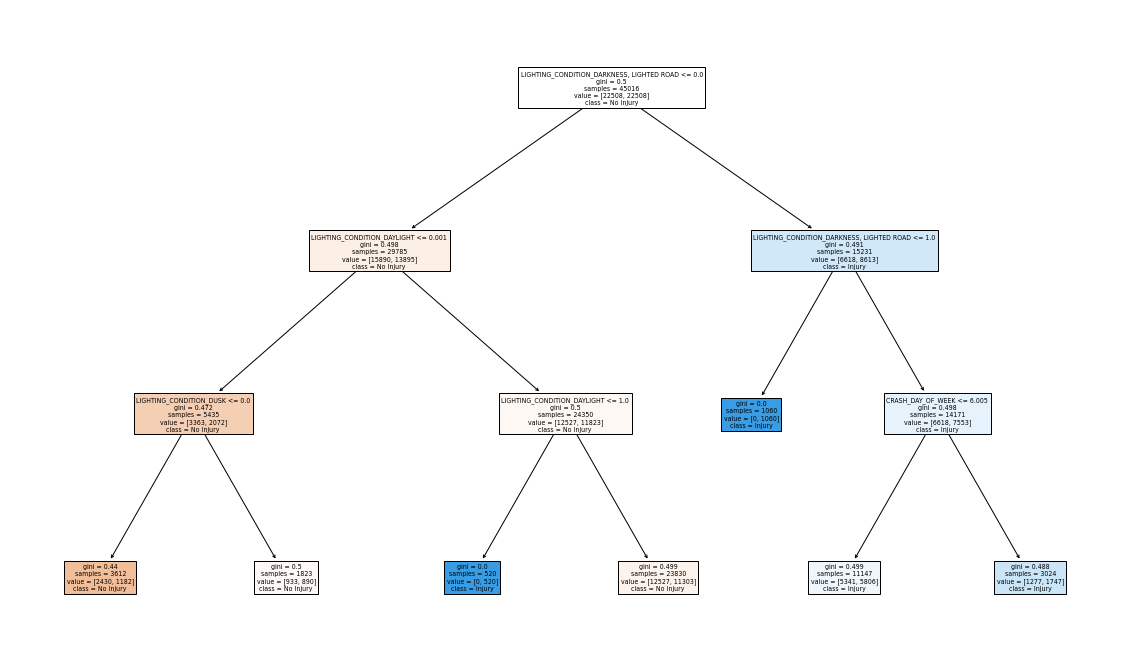

In [39]:
from sklearn import tree

# Plot the decision tree
plt.figure(figsize=(20, 12))
tree.plot_tree(bn_tree_model, feature_names= X_train_encoded.columns.tolist(), class_names=['No Injury', 'Injury'], filled = True)
plt.show()

### BINARY DECISION TREE FEATURE IMPORTANCES

In [40]:
feature_imp = {}
for fi, feature in zip(bn_tree_model.feature_importances_, bn_tree_model.feature_names_in_):
    feature_imp[feature] = fi

feature_imp


{'LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD': 0.5791452323613984,
 'LIGHTING_CONDITION_DAWN': 0.0,
 'LIGHTING_CONDITION_DAYLIGHT': 0.3487380774608818,
 'LIGHTING_CONDITION_DUSK': 0.05792755862291699,
 'LIGHTING_CONDITION_UNKNOWN': 0.0,
 'CRASH_HOUR': 0.0,
 'CRASH_DAY_OF_WEEK': 0.014189131554802841,
 'CRASH_MONTH': 0.0}

### BINARY LOGISTIC REGRESSION 

In [41]:
from sklearn.linear_model import LogisticRegression

# Create an instance of the logistic regression model
bn_logreg_model = LogisticRegression()

# Train the logistic regression model
bn_logreg_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the testing data
y_pred_bn_logreg = bn_logreg_model.predict(X_test_encoded)

# Evaluate the logistic regression 
print("Classification Report:")
print(classification_report(y_test, y_pred_bn_logreg))



Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.71      0.77      7528
           1       0.18      0.34      0.24      1446

    accuracy                           0.65      8974
   macro avg       0.51      0.52      0.50      8974
weighted avg       0.74      0.65      0.68      8974



# COEFFICIENTS FROM BINARY LOGISTIC REGRESSION MODEL

In [90]:
# Get the coefficients and intercept from the logistic regression model
coefficients = bn_logreg_model.coef_
intercept = bn_logreg_model.intercept_

# Create a DataFrame to display the coefficients
coefficients_df = pd.DataFrame(coefficients, columns=X_train_encoded.columns)
coefficients_df['Intercept'] = intercept

# Print the coefficients
print("Coefficients:")
print(coefficients_df)

Coefficients:
   LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD  LIGHTING_CONDITION_DAWN  \
0                                   0.413239                 0.002866   

   LIGHTING_CONDITION_DAYLIGHT  LIGHTING_CONDITION_DUSK  \
0                     0.131102                 0.184448   

   LIGHTING_CONDITION_UNKNOWN  CRASH_HOUR  CRASH_DAY_OF_WEEK  CRASH_MONTH  \
0                   -0.913818   -0.004657           0.003763     0.008305   

   Intercept  
0  -0.219059  


# ODDS RFOM THE COEFFICIENTS OF THE LOGISTIC REGRESSION MODEL

In [92]:
odds = np.exp(coefficients)

# Create a DataFrame to display the odds
odds_df = pd.DataFrame(odds, columns=X_train_encoded.columns)

# Print the odds
print("Odds:")
print(odds_df)

Odds:
   LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD  LIGHTING_CONDITION_DAWN  \
0                                   1.511706                  1.00287   

   LIGHTING_CONDITION_DAYLIGHT  LIGHTING_CONDITION_DUSK  \
0                     1.140084                 1.202554   

   LIGHTING_CONDITION_UNKNOWN  CRASH_HOUR  CRASH_DAY_OF_WEEK  CRASH_MONTH  
0                     0.40099    0.995354            1.00377      1.00834  


Text(0.5, 1.0, 'Binomial Logistic Regression Confusion Matrix')

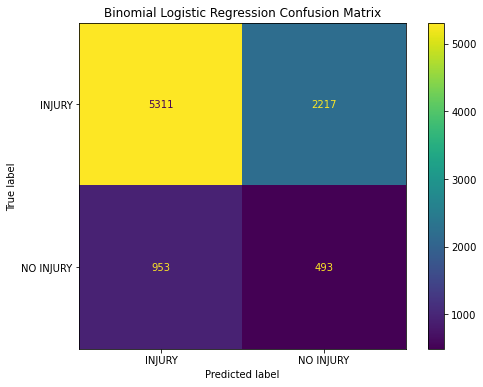

In [57]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

# Get the predictions and the actual values
y_pred_bn_logreg = bn_logreg_model.predict(X_test_encoded)
y_true = y_test

# Create a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['INJURY', 'NO INJURY'])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)

# Set the title
ax.set_title('Binomial Logistic Regression Confusion Matrix')



# MULTINOMIAL MODELING

### TRAIN-TEST SPLIT FOR MULTINOMIAL MODELING.

In [64]:
# Perform a new train-test split with a multiclass target variable
y2 = df_crashes.MOST_SEVERE_INJURY # <------

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y2, random_state = 42)

### PERFORM ONE-HOT ENCODING FOR ANY CATEGORICAL COLUMN(S) FOR MULTINOMIAL MODELING.

In [65]:
from sklearn.preprocessing import OneHotEncoder

# Specify the categorical columns for one-hot encoding
categorical_cols = ['LIGHTING_CONDITION']  

# Create an instance of the OneHotEncoder
ohe = OneHotEncoder(drop='first')

X_train_encoded_2 = pd.DataFrame (ohe.fit_transform(X_train_2[categorical_cols]).toarray(), columns=ohe.get_feature_names_out())
X_test_encoded_2 = pd.DataFrame (ohe.transform(X_test_2[categorical_cols]).toarray(), columns=ohe.get_feature_names_out())

X_train_merge_2 = X_train_2.drop(['LIGHTING_CONDITION'], axis=1)
X_train_merge_2.reset_index(drop=True, inplace=True)
X_test_merge_2 = X_test_2.drop(['LIGHTING_CONDITION'], axis=1)
X_test_merge_2.reset_index(drop=True, inplace=True)

X_train_encoded_2 = pd.concat([X_train_encoded_2, X_train_merge_2], axis=1)
X_test_encoded_2 = pd.concat([X_test_encoded_2, X_test_merge_2], axis=1)

### PERFORM SMOTE TO ADDRESS CLASS IMBALANCE (MULTINOMIAL).

In [72]:
from imblearn.over_sampling import SMOTE

# Create an instance of the SMOTE algorithm
smote_2 = SMOTE(random_state = 42)

# Apply SMOTE to the encoded training data
X_train_resampled_2, y_train_resampled_2 = smote_2.fit_resample(X_train_encoded_2, y_train_2) # <----------------------


### APPLY A DUMMY CLASSIFIER AS THE BASELINE MODEL AGAIN.

In [75]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_resampled_2, y_train_resampled_2)

y_pred_dummy_clf = dummy_clf.predict(X_test_encoded_2)

# Evaluate the model with a classification report
report = classification_report(y_test_2, y_pred_dummy_clf)
print(report)


                          precision    recall  f1-score   support

                   FATAL       0.00      1.00      0.00         8
   INCAPACITATING INJURY       0.00      0.00      0.00       178
 NO INDICATION OF INJURY       0.00      0.00      0.00      7528
NONINCAPACITATING INJURY       0.00      0.00      0.00       790
   REPORTED, NOT EVIDENT       0.00      0.00      0.00       470

                accuracy                           0.00      8974
               macro avg       0.00      0.20      0.00      8974
            weighted avg       0.00      0.00      0.00      8974



c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### APPLY A MULTINOMIAL DECISION TREE

In [76]:
# Create the multinomial decision tree classifier
mn_tree_model = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth = 3)

# Fit the model to the SMOTE training data
mn_tree_model.fit(X_train_resampled_2, y_train_resampled_2)

# Predict on the test data
y_pred_2 = mn_tree_model.predict(X_test_encoded_2)

# Evaluate the model's performance
classification_report_2 = classification_report(y_test_2, y_pred_2)

# Print the classification report
print("Classification Report:")
print(classification_report_2)

Classification Report:
                          precision    recall  f1-score   support

                   FATAL       0.00      0.12      0.00         8
   INCAPACITATING INJURY       0.02      0.06      0.03       178
 NO INDICATION OF INJURY       0.85      0.16      0.27      7528
NONINCAPACITATING INJURY       0.09      0.13      0.11       790
   REPORTED, NOT EVIDENT       0.06      0.59      0.10       470

                accuracy                           0.18      8974
               macro avg       0.20      0.21      0.10      8974
            weighted avg       0.72      0.18      0.24      8974



# MULTINOMIAL DECISION TREE VISUALIZATION

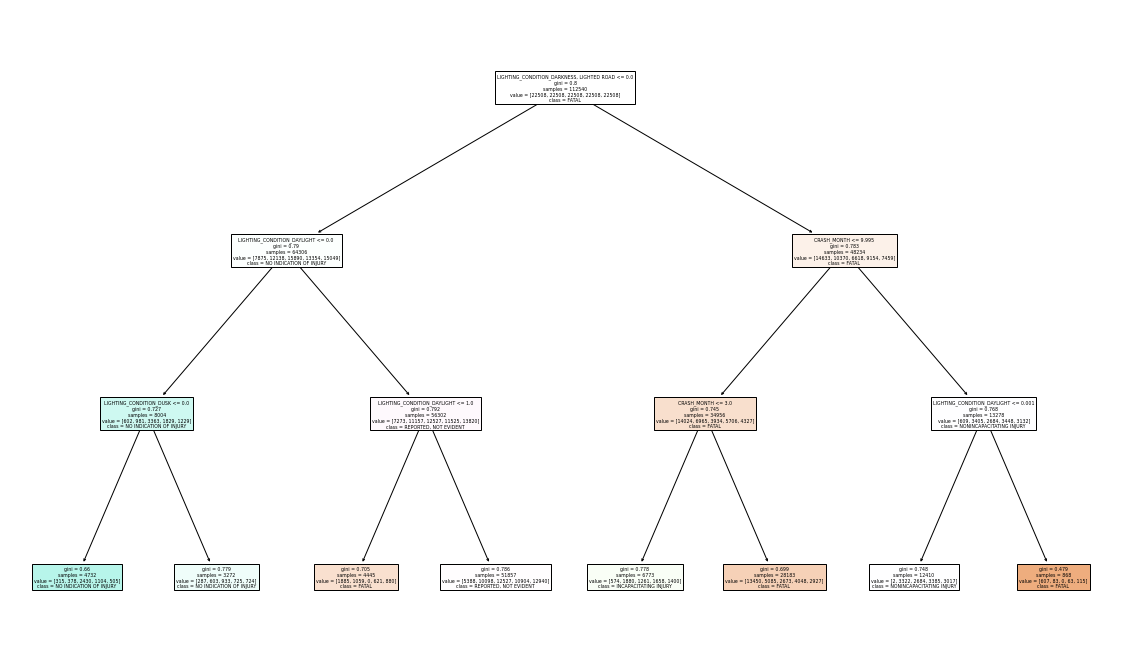

In [79]:
from sklearn import tree

# Get the unique values from the 'MOST_SEVERE_INJURY' column
target_class_names = np.unique(df_crashes['MOST_SEVERE_INJURY']).tolist()

# Plot the decision tree
plt.figure(figsize=(20, 12))
tree.plot_tree(mn_tree_model, feature_names= X_train_encoded_2.columns.tolist(), class_names = target_class_names, filled = True)
plt.show()

### MULTINOMIAL DECISION TREE FEATURE IMPORTANCES

In [80]:
feature_imp_2 = {}
for fi, feature in zip(mn_tree_model.feature_importances_, mn_tree_model.feature_names_in_):
    # feature_imp[feature] = fi
    print(fi, feature)


0.24907245742022144 LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD
0.0 LIGHTING_CONDITION_DAWN
0.2767544152758435 LIGHTING_CONDITION_DAYLIGHT
0.02574958138793218 LIGHTING_CONDITION_DUSK
0.0 LIGHTING_CONDITION_UNKNOWN
0.0 CRASH_HOUR
0.0 CRASH_DAY_OF_WEEK
0.44842354591600286 CRASH_MONTH


### MULTINOMIAL LOGISTIC REGRESSION MODEL

In [87]:
# Create an instance of the multinomial logistic regression model
mn_logreg_model = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', random_state = 42)

# Fit the model on the training data
mn_logreg_model.fit(X_train_resampled_2, y_train_resampled_2)

# Predict on the test data
y_pred_mn_logreg = mn_logreg_model.predict(X_test_encoded_2)

# Evaluate the accuracy of the model
print("Classification Report:")
print(classification_report(y_test_2, y_pred_2))


c:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
                          precision    recall  f1-score   support

                   FATAL       0.00      0.12      0.00         8
   INCAPACITATING INJURY       0.02      0.06      0.03       178
 NO INDICATION OF INJURY       0.85      0.16      0.27      7528
NONINCAPACITATING INJURY       0.09      0.13      0.11       790
   REPORTED, NOT EVIDENT       0.06      0.59      0.10       470

                accuracy                           0.18      8974
               macro avg       0.20      0.21      0.10      8974
            weighted avg       0.72      0.18      0.24      8974



# COEFFICIENTS FROM THE MULTINOMIAL LOGISTIC REGRESSION MODEL

In [88]:
coefficients = mn_logreg_model.coef_

# Print the coefficients
for i, class_name in enumerate(mn_logreg_model.classes_):
    print(f"Coefficients for class '{class_name}':")
    for j, feature_name in enumerate(X_train_encoded_2.columns):
        print(f"{feature_name}: {coefficients[i, j]}")
    print()

Coefficients for class 'FATAL':
LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD: -0.08342714922539403
LIGHTING_CONDITION_DAWN: -1.0784672713471242
LIGHTING_CONDITION_DAYLIGHT: -0.880712986434862
LIGHTING_CONDITION_DUSK: 0.20553951612889756
LIGHTING_CONDITION_UNKNOWN: -0.3423905415827352
CRASH_HOUR: -0.025491010196693628
CRASH_DAY_OF_WEEK: 0.03927227123349062
CRASH_MONTH: -0.07776783037073115

Coefficients for class 'INCAPACITATING INJURY':
LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD: 0.34396708322589753
LIGHTING_CONDITION_DAWN: -0.02061435156303981
LIGHTING_CONDITION_DAYLIGHT: 0.22440758345031106
LIGHTING_CONDITION_DUSK: -0.0060958979951853225
LIGHTING_CONDITION_UNKNOWN: 0.13729872698439577
CRASH_HOUR: -0.0053338218595217635
CRASH_DAY_OF_WEEK: 0.010960496738882759
CRASH_MONTH: 0.022585974197239976

Coefficients for class 'NO INDICATION OF INJURY':
LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD: -0.4325225561940959
LIGHTING_CONDITION_DAWN: 0.6683014538620997
LIGHTING_CONDITION_DAYLIGHT: -0.035144724

# ODDS FROM THE COEFFICIENTS OF THE MULTINOMIAL LOGISTIC REGRESSION MODEL

In [89]:
odds = np.exp(coefficients)

# Print the odds
for i, class_name in enumerate(mn_logreg_model.classes_):
    print(f"Odds for class '{class_name}':")
    for j, feature_name in enumerate(X_train_encoded_2.columns):
        print(f"{feature_name}: {odds[i, j]}")
    print()

Odds for class 'FATAL':
LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD: 0.9199581038905521
LIGHTING_CONDITION_DAWN: 0.34011643253996665
LIGHTING_CONDITION_DAYLIGHT: 0.41448728249446354
LIGHTING_CONDITION_DUSK: 1.228187513219042
LIGHTING_CONDITION_UNKNOWN: 0.7100708383620885
CRASH_HOUR: 0.9748311424665776
CRASH_DAY_OF_WEEK: 1.040053621785724
CRASH_MONTH: 0.9251792001225231

Odds for class 'INCAPACITATING INJURY':
LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD: 1.4105322045735622
LIGHTING_CONDITION_DAWN: 0.9795966716589808
LIGHTING_CONDITION_DAYLIGHT: 1.251581039201794
LIGHTING_CONDITION_DUSK: 0.9939226442945642
LIGHTING_CONDITION_UNKNOWN: 1.1471707882101385
CRASH_HOUR: 0.994680377711082
CRASH_DAY_OF_WEEK: 1.011020783037869
CRASH_MONTH: 1.0228429684874687

Odds for class 'NO INDICATION OF INJURY':
LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD: 0.6488702169268294
LIGHTING_CONDITION_DAWN: 1.9509207758319855
LIGHTING_CONDITION_DAYLIGHT: 0.9654656796114831
LIGHTING_CONDITION_DUSK: 0.8793322743463671
LIGHT